In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as lg
from numpy import*
import scipy as sp
from numpy.random import randn
from scipy.sparse.linalg import svds
from numpy.linalg import norm
from scipy.special import logsumexp
import math
import time
import json
import matplotlib.pyplot as plt

In [2]:
from bs4 import BeautifulSoup
import urllib.request

def get_bookinf(asin):
    try:
        url = 'https://www.abebooks.com/servlet/SearchResults?cm_sp=SearchF-_-topnav-_-Results&kn=' + str(asin) +'&sts=t'
        page = urllib.request.urlopen(url)
        soup = BeautifulSoup(page,'html.parser')
        div = soup.find('div', attrs = {'id':'book-1'})
        try:
            results = div.find_all('meta')
        except AttributeError:
            return "no book found"
        inf = []
        for result in results:
            inf.append(result['content'])
        return [inf[1],inf[2]]
    except IOError:
        return "no book found"

In [3]:
def get_data(filename):
    data = []
    for line in open(filename, 'r'):
        js = json.loads(line)
        data.append([js['asin'], js['reviewerID'], js['overall']])
    
    #random.shuffle(data)
    return data[:int(len(data)*0.4)]
    #return data

def get_book_id(data):
    book_id = []
    for row in data:
        if row[0] not in book_id:
            book_id.append(row[0])
    return book_id

def get_user_id(data):
    user_id = []
    for row in data:
        if row[1] not in user_id:
            user_id.append(row[1])
        
    return user_id

def get_book_set(book_id):
    count = 0
    book_set = {}
    for book in sorted(book_id):
        book_set[book] = count
        count += 1
    return book_set

def get_user_set(user_id):
    count = 0
    user_set = {}
    for user in sorted(user_id):
        user_set[user] = count
        count += 1
    return user_set

def get_matrix(user_set, book_set, train_data):
    matrix = np.zeros((len(book_set), len(user_set)))
    for line in train_data:
        matrix[book_set[line[0]]][user_set[line[1]]] = float(line[2])
    return matrix

def do_svd(matrix):
    c = int(matrix.shape[0]/2)
    col_p = ((norm(matrix,ord = 2, axis = 0))**2)/norm(matrix)**2
    col_c = range(0,matrix.shape[1])
    col_dra  = np.random.choice(col_c, c, p = col_p)
    M_col = matrix[:,col_dra]
    Ur_col, D_col, Vr_col = svds(M_col, k = int(matrix.shape[0]/4))
    row_p = ((norm(matrix,ord = 2, axis = 1))**2)/norm(matrix)**2
    row_c = range(0,matrix.shape[0])
    row_dra = np.random.choice(row_c, c, p = row_p)
    M_row = matrix[row_dra,:]
    Ur_row, D_row, Vr_row = svds(M_row, k = int(matrix.shape[0]/4))
    return Ur_col, Vr_row

def get_book_rate(train_data):
    book_rate = {}
    for line in train_data:
        book_id, user_id, rating = line[0], line[1], line[2]
        if book_id not in book_rate.keys():
            book_rate[book_id] = [(user_id, rating)]
        else:
            book_rate[book_id].append((user_id,rating))
    return book_rate

def get_cossim(vec1, vec2):
    # good point
    res = np.exp(logsumexp(np.dot(vec1,vec2)) - logsumexp((lg.norm(vec1)*lg.norm(vec2))))
    #return np.dot(vec1,vec2)/(lg.norm(vec1)*lg.norm(vec2))
    return res

def get_test(book_fa, user_fa, test_data, train_data, book_rate, book_set, user_set):
    rate_summ = pd.DataFrame(train_data)
    overall_mean = rate_summ[2].mean()
    book_mean = rate_summ[2].groupby(rate_summ[0]).mean()
    user_mean = rate_summ[2].groupby(rate_summ[1]).mean()
    rate_tests = []
    in_fac_over = []
    for line in test_data:
        user_id, book_id = line[1], line[0]
        user_num = user_set[user_id]
        book_num = book_set[book_id]
        if (user_id not in user_mean and book_id not in book_rate.keys()):
            rate_pre =[0, overall_mean]
            in_fac_over.append(0)
        elif (book_id not in book_rate.keys() and user_id in user_mean):
            rate_pre =[0, 0.6*user_mean[user_id] + 0.4*overall_mean]
            in_fac_over.append(0)
        elif (book_id in book_rate.keys() and user_id not in user_mean):
            in_fac = 0
            for lines in book_rate[book_id]:
                user_num_get = user_set[lines[0]]
                in_fac += get_cossim(user_fa[:,user_num], user_fa[:,user_num_get])*(float(lines[1]) - user_mean[lines[0]])
            rate_pre = [in_fac, 0.6*book_mean[book_id] + 0.4*overall_mean]
            in_fac_over.append(in_fac)
        else:
            in_fac = 0
            for lines in book_rate[book_id]:
                user_num_get = user_set[lines[0]]
                in_fac += get_cossim(user_fa[:,user_num], user_fa[:,user_num_get])*(float(lines[1]) - user_mean[lines[0]])
            rate_pre = [in_fac, 0.9*user_mean[user_id] + 0.1*book_mean[book_id]]
            in_fac_over.append(in_fac)
        rate_tests.append((user_id, book_id, rate_pre))
    fac_max = max(in_fac_over)
    fac_min = min(in_fac_over)
    fac_mean = mean(in_fac_over)
    rate_test_out = []
    for rows in rate_tests:
        if rows[2][0] == 0:
            rate_test_out.append((rows[0], rows[1], rows[2][1]))
        else:  
            rate_test_out.append((rows[0], rows[1],0.1*((rows[2][0] - fac_mean)/(fac_max - fac_min)) + rows[2][1]))
    return rate_test_out

In [4]:
def get_mse(truth, res):
    error = []
    for i in range(len(res)):
        error.append(truth[i][2] - res[i][2])
    sqr_err = []
    for val in error:
        sqr_err.append(val*val)
    return sum(sqr_err)/len(sqr_err)

In [5]:
data = get_data('split_0.json')
#use the 80000 data point

In [6]:
#random.shuffle(data)

In [7]:
book_id = get_book_id(data)

In [8]:
len(book_id)

2041

In [9]:
user_id = get_user_id(data)

In [10]:
train_data = data[:int(len(data)*0.995)]
test_data = data[int(len(data)*0.995):]

In [11]:
user_set = get_user_set(user_id)
book_set = get_book_set(book_id)

In [12]:
matrix = get_matrix(user_set, book_set, train_data)

In [13]:
book_fa, user_fa= do_svd(matrix)

In [14]:
book_rate = get_book_rate(train_data)
rate_test_out = get_test(book_fa, user_fa, test_data, train_data, book_rate, book_set, user_set)

In [15]:
get_mse(test_data,rate_test_out)

0.8150664301678628

In [16]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>


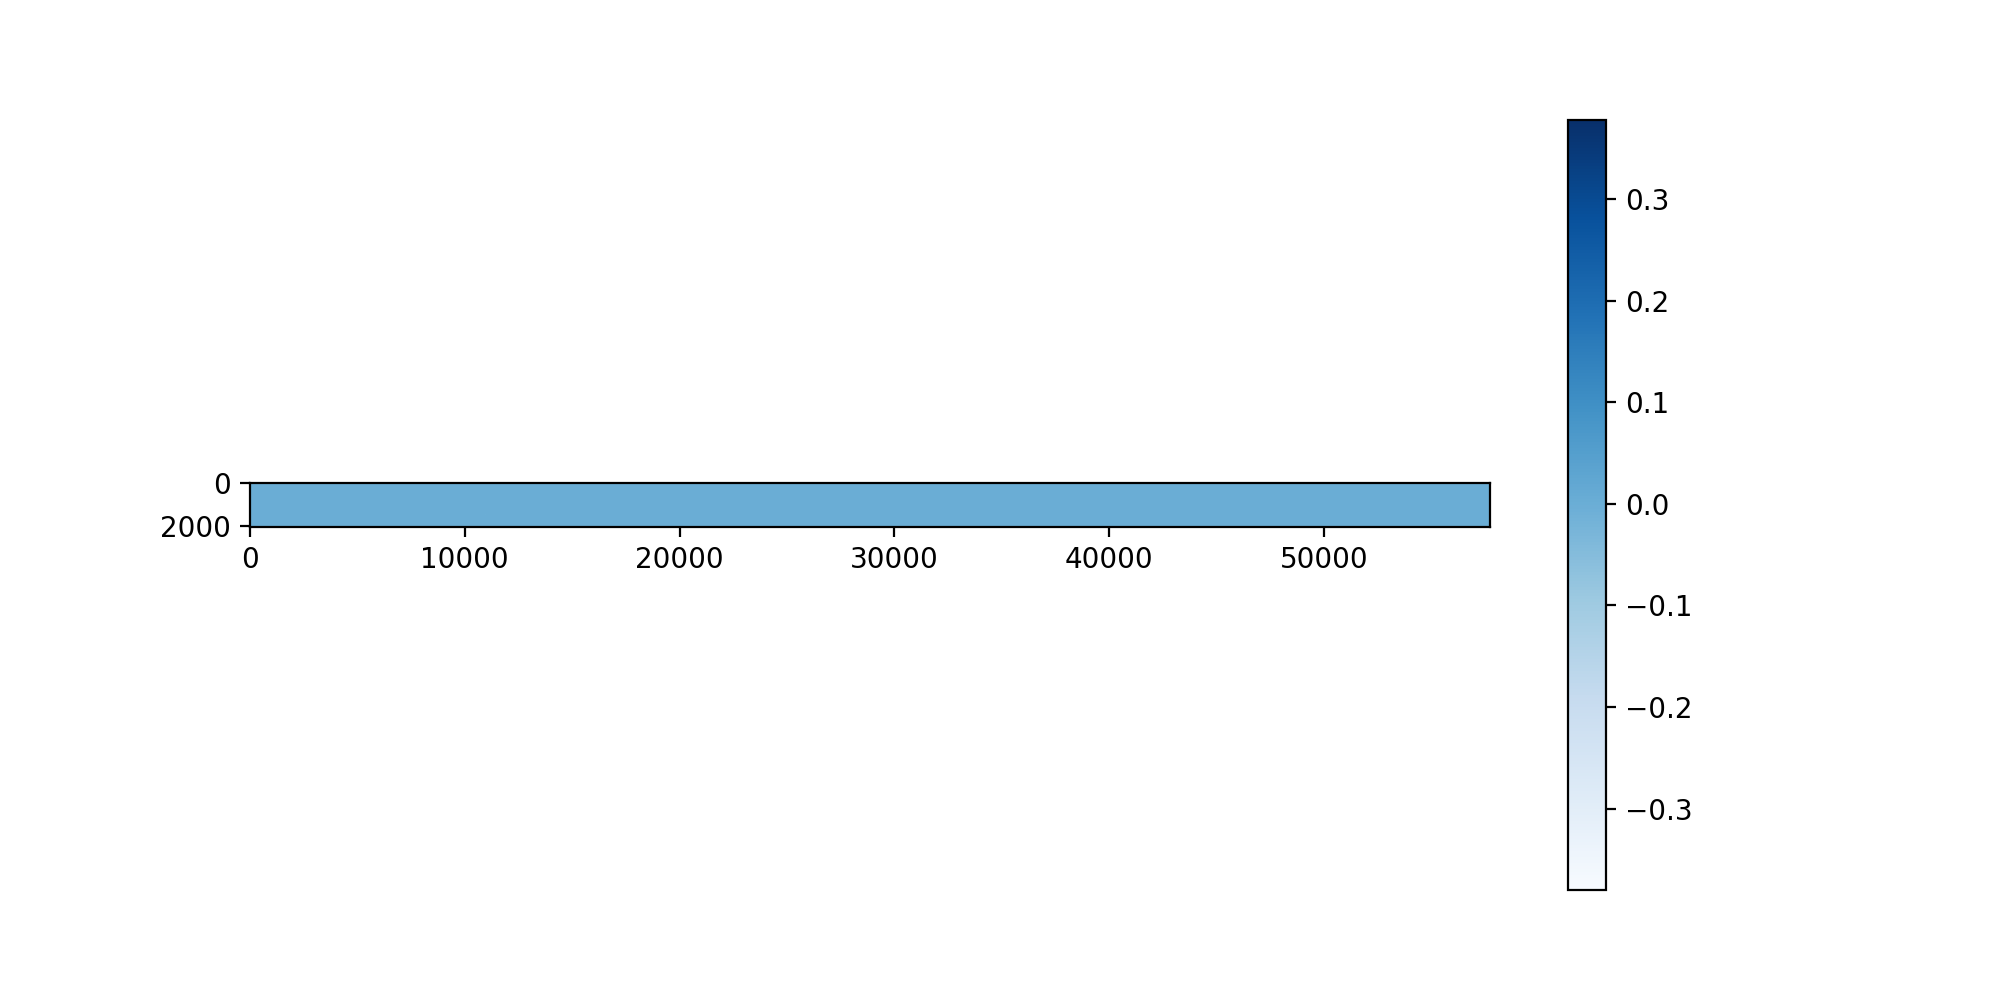

In [32]:
%matplotlib notebook
plt.figure(figsize = (10,5))
plt.imshow(np.dot(book_fa, user_fa),cmap= plt.cm.Blues)
plt.colorbar()